# **Machine Learning for Churn Prediction**

This notebook encompass data transformation for model creation, model creation, model selection, hiperparameter optimization and model saving.

Importing necessary libraries and the Python file, `helper.py`, containing functions designed for a more streamlined and readable code.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from statsmodels.stats.outliers_influence import variance_inflation_factor


# importing python file helpers.py and helpers_2.py
from helpers import *
from helpers_2 import *

In [2]:
SEED = 20
np.random.seed(SEED)

In [3]:
df = pd.read_csv('data/churn_data.csv').drop(columns='customerID')
df.head()

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0,Female,0,1,1,9,1,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.6,593.30
1,0,Male,0,0,0,9,1,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40
2,1,Male,0,0,0,4,1,0,Fiber optic,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85
3,1,Male,1,1,0,13,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85
4,1,Female,1,1,0,3,1,0,Fiber optic,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40


The target variable is imbalanced as we saw in the last notebook
- 5174 instances of no Churn and 1869 of Churn

In [4]:
# Distribution of target variable
df.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

Creating Potential new features for fitting our ML models

In [5]:
df.account_Charges_Monthly.describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: account_Charges_Monthly, dtype: float64

In [6]:
df['Average monthly spend'] = df['account_Charges_Total'] / df['customer_tenure']
df['Average monthly spend'].fillna(0, inplace=True)
df['Average monthly Spend - Present monthly spend'] = df['Average monthly spend'] - df['account_Charges_Monthly']

## **Creating model Pipelines**

A pipeline is a series of data processing steps (or transformers) that are applied to the data before using a final estimator. Transformers play a crucial role in enhancing model performance. Common transformers include scaling methods, encoding methods, and others.


**Scaling**

1. Scaling ensures that each feature is on a similar scale.
2. Prevents features from dominating based solely on its scale
3. Help convergence of certain algorithms.
4. Beneficial for algorithms that rely on distance calculations, such as K-Nearest Neighbors (KNN).
4. Make the model more robust to outliers and noise in the data.

**Enconding**

1. Many machine learning models require numerical input; encoding converts non-numerical data into a numerical format to make it compatible with these models.
2. ``One-Hot Encoding``: This creates a binary column for each category in the original column. It's especially useful when there's no ordinal relationship between categories.
3. ``Ordinal Encoding``: Used for categorical variables with a clear ordinal relationship, this method assigns a unique integer to each category based on the defined order.

In [7]:
# Defining the features (x) and the response variable (y)
X = df.drop(columns='Churn')
y = df['Churn']

Creating separated pipeline for numerical columns and categoriacal columns. We will be applying the ``MinMaxScaler`` in the numerical columns, and the ``OneHotEncoder`` in the categorical columns. Since we want this process to happen within specific columns, we merged both pipelines into a column transformer to use in our final pipeline.

In [8]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

num_cols = ['customer_tenure', 'account_Charges_Monthly','account_Charges_Total', 'Average monthly spend', 'Average monthly Spend - Present monthly spend']
cat_col = ['customer_gender', 'internet_InternetService', 'account_Contract', 'account_PaymentMethod']

# numeric Pipeline
num_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])

# categorical Pipeline
cat_pipeline = Pipeline(steps=[
    ('onehotencoder', OneHotEncoder(drop='first'))
])

# merging cat and num pipelines into a columnstransformer, so it can alter just specific columns
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_col), 
    ],
    remainder='passthrough', #remainder=’passthrough’ is specified to ignore other columns in a dataframe.
    n_jobs=-1 #n_job = -1 means using all processors to run in parallel.
)

### **Random Forest sample pipeline**

**Important Note:** Oversampling techniques, like [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html), should be applied exclusively to the training data. This is to prevent data leakage which could artificially inflate model performance. By incorporating SMOTE into our pipeline, we ensure that it only affects the training data, as SMOTE lacks a *transform* method.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# RandomForest Pipeline --> Concatanating column transformer, resampler and classifier in the final Pipeline
dt_pipe = Pipeline([
    ('preprocessor', col_trans),
    ('resampler', SMOTE(random_state=SEED)),  # Oversampling will be applied only to the training data
    ('classifier', RandomForestClassifier(random_state=SEED))
])

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# Fitting the pipeline
dt_pipe.fit(X_train, y_train)
# Predicting
y_pred = dt_pipe.predict(X_test)

# Calculate and print metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)

print(f"Accuracy: {round(accuracy, 3)}\n")
print(f"Precision: {round(precision, 3)}\n")
print(f"Recall: {round(recall, 3)}\n")
print(f"F1 Score: {round(f1, 3)}\n")
print(f"ROC AUC: {round(roc_auc, 3)}\n")

Accuracy: 0.779

Precision: 0.58

Recall: 0.61

F1 Score: 0.595

ROC AUC: 0.725



In [10]:
# Pipeline object
dt_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['customer_tenure',
                                                   'account_Charges_Monthly',
                                                   'account_Charges_Total',
                                                   'Average monthly spend',
                                                   'Average monthly Spend - '
                                                   'Present monthly spend']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['customer_gender',
                                                   'internet_InternetService',
                                                   'account_Contract',
                                                   'account_PaymentMethod'])])),
                ('resampler', SMOTE(random_state=20)),
                ('classifier', RandomForestClassifier(random_state=20))])

In [11]:
# Pipeline preprocessor
dt_pipe['preprocessor']

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('num_pipeline',
                                 Pipeline(steps=[('scale', MinMaxScaler())]),
                                 ['customer_tenure', 'account_Charges_Monthly',
                                  'account_Charges_Total',
                                  'Average monthly spend',
                                  'Average monthly Spend - Present monthly '
                                  'spend']),
                                ('cat_pipeline',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['customer_gender', 'internet_InternetService',
                                  'account_Contract',
                                  'account_PaymentMethod'])])

In [12]:
# Pipeline classifier
dt_pipe['classifier']

RandomForestClassifier(random_state=20)

### **Running multiples Pipelines to create base-line models**

Instancing initial models for base line measurement

In [13]:
# Importing models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=SEED)

# Random Forest Classifier
rf = RandomForestClassifier(random_state=SEED)

# Logistic Regression
lr = LogisticRegression(random_state=SEED, max_iter=1000)

# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Support Vector Machine Classifier
svc = SVC(random_state=SEED)

# Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=SEED)

# Gaussian Naive Bayes
gnb = GaussianNB()

# AdaBoost Classifier
adb = AdaBoostClassifier(random_state=SEED)

# Multi-layer Perceptron Classifier
mlp = MLPClassifier(early_stopping=True, random_state=SEED)

#
xg = XGBClassifier(random_state=SEED)

# storing models in a list for looping
classifiers = [
    dt,
    rf,
    lr,
    knn,
    svc,
    gb,
    gnb,
    adb,
    mlp,
    xg
]

In [14]:
num_cols = ['customer_tenure', 'account_Charges_Monthly', 'account_Charges_Total', 'Average monthly spend', 'Average monthly Spend - Present monthly spend']
cat_cols = ['customer_gender', 'internet_InternetService', 'account_Contract', 'account_PaymentMethod']

# Creating the column transformer
col_trans = create_cols_trans(num_cols, cat_cols)

# Base pipeline with SMOTE
smote_base_pipe = Pipeline([
    ('preprocessor', col_trans),
    ('resampler', SMOTE(random_state=SEED)),
    ('classifier', None)
])

# Dictionary to store pipelines with SMOTE
pipelines_smote = generate_pipelines(classifiers, smote_base_pipe)

In [15]:
base_line_classifier_df = fit_compare_multiple_pipelines(pipelines_smote, X, y, resampler='SMOTE')
base_line_classifier_df

,Model_name,Accuracy,Precision,Recall,F1,ROC auc,Resampler
5,GradientBoostingClassifier,0.784244,0.577434,0.697861,0.631961,0.756660,SMOTE
7,AdaBoostClassifier,0.759404,0.533081,0.754011,0.624585,0.757682,SMOTE
8,MLPClassifier,0.765082,0.543611,0.716578,0.618224,0.749593,SMOTE
2,LogisticRegression,0.745919,0.514545,0.756684,0.612554,0.749357,SMOTE
4,SVC,0.759404,0.535354,0.708556,0.609896,0.743167,SMOTE
6,GaussianNB,0.733144,0.498252,0.762032,0.602537,0.742369,SMOTE
1,RandomForestClassifier,0.779276,0.580153,0.609626,0.594524,0.725103,SMOTE
9,XGBClassifier,0.773598,0.571059,0.590909,0.580815,0.715261,SMOTE
3,KNeighborsClassifier,0.682044,0.433692,0.647059,0.519313,0.670872,SMOTE
0,DecisionTreeClassifier,0.711143,0.464208,0.572193,0.512575,0.666773,SMOTE


Creating a dictionary to store the pipeline for each model, but **without the SMOTE resampler**, so we can compare the results

In [16]:
# no resampler base pipeline
no_resampler_base_pipe = Pipeline([
    ('preprocessor', col_trans),
    ('classifier', None)
])

pipelines_no_oversampling = generate_pipelines(classifiers, no_resampler_base_pipe)

In [17]:
base_line_classifier_no_oversampling_df= fit_compare_multiple_pipelines(pipelines_no_oversampling, X, y, resampler='Nothing')
base_line_classifier_no_oversampling_df

,Model_name,Accuracy,Precision,Recall,F1,ROC auc,Resampler
6,GaussianNB,0.740951,0.508108,0.754011,0.607104,0.745121,Nothing
2,LogisticRegression,0.793471,0.630915,0.534759,0.578871,0.710858,Nothing
8,MLPClassifier,0.787083,0.609467,0.550802,0.578652,0.711633,Nothing
5,GradientBoostingClassifier,0.803407,0.672598,0.505348,0.577099,0.708229,Nothing
7,AdaBoostClassifier,0.796309,0.643564,0.521390,0.576071,0.708521,Nothing
4,SVC,0.791341,0.641844,0.483957,0.551829,0.693186,Nothing
1,RandomForestClassifier,0.785664,0.626761,0.475936,0.541033,0.686760,Nothing
9,XGBClassifier,0.780696,0.608696,0.486631,0.540862,0.686794,Nothing
3,KNeighborsClassifier,0.752307,0.534247,0.521390,0.527740,0.678570,Nothing
0,DecisionTreeClassifier,0.720369,0.473118,0.470588,0.471850,0.640608,Nothing


Creating a dictionary to store the pipeline for each model, using an **undersmapling technique**, so we can compare the results

In [18]:
from imblearn.under_sampling import NearMiss 

# undersampling base pipeline
undersampling_base_pipe = Pipeline([
    ('preprocessor', col_trans),
    ('resampler', NearMiss()),
    ('classifier', None)
])

pipelines_undersampling = generate_pipelines(classifiers, undersampling_base_pipe)

In [19]:
base_line_classifier_undersamlpling_df= fit_compare_multiple_pipelines(pipelines_undersampling, X, y, resampler='NearMiss')
base_line_classifier_undersamlpling_df

,Model_name,Accuracy,Precision,Recall,F1,ROC auc,Resampler
2,LogisticRegression,0.623137,0.394631,0.786096,0.525469,0.675174,NearMiss
6,GaussianNB,0.606813,0.384615,0.802139,0.519931,0.669185,NearMiss
8,MLPClassifier,0.597587,0.378310,0.802139,0.514139,0.662905,NearMiss
7,AdaBoostClassifier,0.530163,0.334862,0.780749,0.468700,0.610181,NearMiss
5,GradientBoostingClassifier,0.506742,0.324206,0.791444,0.459984,0.597654,NearMiss
4,SVC,0.492548,0.319958,0.810160,0.458743,0.593969,NearMiss
3,KNeighborsClassifier,0.574166,0.346049,0.679144,0.458484,0.607688,NearMiss
1,RandomForestClassifier,0.489709,0.305962,0.727273,0.430721,0.565569,NearMiss
9,XGBClassifier,0.490419,0.299534,0.687166,0.417208,0.553245,NearMiss
0,DecisionTreeClassifier,0.507452,0.296954,0.625668,0.402754,0.545201,NearMiss


#### Comparing the Results

We can observe that the model performance, when using the oversampling technique (SMOTE), increased significantly. Therefore we will maintain the oversampling in our model pipeline.

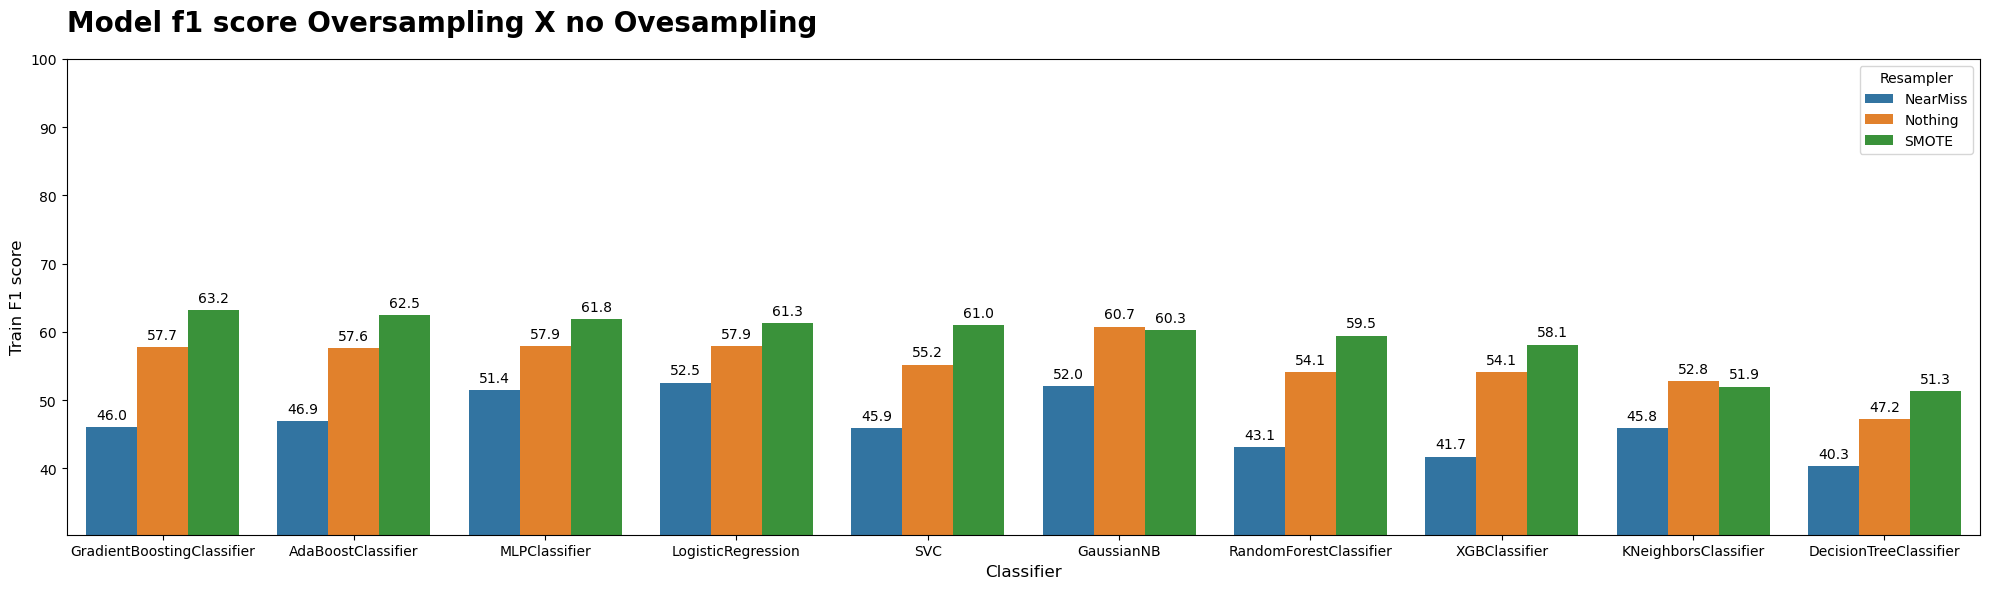

In [20]:
base_line_comparison = pd.concat([base_line_classifier_df, base_line_classifier_no_oversampling_df, base_line_classifier_undersamlpling_df])
base_line_comparison['F1'] = base_line_comparison['F1']*100 
ymin = base_line_comparison['F1'].min()

plt.figure(figsize=(20,6))
ax = sns.barplot(x='Model_name', y='F1', data=base_line_comparison, hue='Resampler', hue_order=['NearMiss', 'Nothing', 'SMOTE'])
plt.title('Model f1 score Oversampling X no Ovesampling', size=20, fontweight='bold', pad=20, loc='left')
plt.ylabel('Train F1 score', size=12)
plt.xlabel('Classifier', size=12)
plt.ylim(ymin-10, 100)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')
plt.tight_layout()
plt.show()

### **Optimizing Model**

We aim to optimize our model through both **hyperparameter tuning and feature selection**. Ideally, these processes should be conducted concurrently, as the features chosen can influence the optimal hyperparameters, and vice versa.

With this perspective, we'll first undertake a preliminary hyperparameter tuning to ensure there are no obviously suboptimal settings. Using this initial set of hyperparameters, we'll then proceed with feature selection.

- **Hyperparameter Tunning**
    - ``Hyperparameter tuning`` is the process of finding the best hyperparameters for a given machine learning algorithm and dataset.
    - ``Hyperparameters`` are certain values or weights that determine the learning process of an algorithm.
    - ``RandomizedSearch`` or ``GridSearch`` are techniques used to find the optimal hyperparameters for a machine learning model.
        - The performance of a machine learning model is highly dependent on the values of its hyperparameters.
        - Choosing the right hyperparameters is critical for achieving good performance.
    - ``StratifiedKFold`` ensures the population is divided into homogeneous subgroups where the right amount of instances is sampled from each class.
        - Guarantees that the test set is representative of the overall population.


- **Feature Selection**
    - Testing different feature combinations
        - Forward Selection (rfecv)
        - chi2

#### **What metrics to optimize?**
Before we begin optimizing our model, we need to determine the metric we aim to optimize. For classification tasks, the most common metrics include accuracy, recall, precision, F1-score, and AUC.

- **Accuracy:** Represents the percentage of predictions that are correct.
- **Recall:** Represents the percentage of actual positive cases (in our case, Churn) that were correctly identified.
- **Precision:** Represents the percentage of predicted positive cases that were actually positive.
- **F1-score:** A harmonic mean of precision and recall, it provides a balance between the two metrics, especially when the class distribution is uneven.
- **Area under the curve (Auc):** Represents the ability of the model to distinguish between the positive and negative classes. A higher AUC indicates a better model.

For churn prediction, the optimal metric can vary based on the unique requirements and constraints of each business. For instance:

- If the focus is on **proactively reaching out** to as many potential churners as possible, **recall** might be prioritized.
- If the **retention strategy or campaign is expensive** and should only target very likely churners, **precision** might be more important.
- In many cases, a **balance** between recall and precision (like the **F1-score**) is sought.

In this notebook, we aim to optimize the **``F1-score``**, as it offers a balanced perspective by harmonizing both recall and precision, providing a holistic view of our model's performance.

#### Optimizing RandomForestClassifier

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

# Random Forest Classifier
dt_pipe = Pipeline([
    ('preprocessor', col_trans),
    ('resampler', SMOTE(random_state=SEED)), 
    ('classifier', RandomForestClassifier(random_state=SEED))
])

# Intancing StratifiedKFold
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Random Forest RandomizedSearch parameters
rf_param_grid_pipeline = {
    'classifier__max_features': ['log2', 'sqrt'],
    'classifier__max_depth': list(range(4, 20, 1)) + [None],
    'classifier__min_samples_leaf': list(range(1, 11, 1)),
    'classifier__min_samples_split': list(range(2, 11, 1)),
    'classifier__criterion': ['gini', 'entropy']
}

# Instanciate RandomizedSearch
gridsearch = RandomizedSearchCV(pipelines_smote['RandomForestClassifier'], rf_param_grid_pipeline, scoring={'f1': 'f1'}, refit='f1', n_iter=60, 
                                     cv=strat_kfold, return_train_score=True, n_jobs=-1, random_state=SEED)

In [22]:
# Fit model
dt_clf = gridsearch.fit(X_train, y_train)
dt_clf.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['customer_tenure',
                                                   'account_Charges_Monthly',
                                                   'account_Charges_Total',
                                                   'Average monthly spend',
                                                   'Average monthly Spend - '
                                                   'Present monthly spend']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['customer_gender',
                                                   'internet_InternetService',
                                                   'account_Contract',
                                                   'account_PaymentMethod'])])),
                ('resampler', SMOTE(random_state=20)),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features='log2', min_samples_leaf=8,
                                        min_samples_split=5,
                                        random_state=20))])

In [23]:
# Visualizing the results from the Hyperparameters search with RandomizedSearchCV
test = pd.DataFrame(dt_clf.cv_results_)
test.sort_values(by='mean_test_f1', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_features,param_classifier__max_depth,param_classifier__criterion,params,...,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1
38,1.665039,0.055120,0.096256,0.041510,5,8,log2,8,entropy,"{'classifier__min_samples_split': 5, 'classifi...",...,0.640747,0.024101,1,0.680113,0.689559,0.683239,0.688583,0.698959,0.688090,0.006445
3,2.256421,0.198847,0.177816,0.087062,2,6,sqrt,8,entropy,"{'classifier__min_samples_split': 2, 'classifi...",...,0.638967,0.026493,2,0.682995,0.694180,0.684736,0.695221,0.703704,0.692167,0.007561
56,1.924321,0.165519,0.060159,0.003216,5,6,sqrt,8,entropy,"{'classifier__min_samples_split': 5, 'classifi...",...,0.638967,0.026493,2,0.682995,0.694180,0.684736,0.695221,0.703704,0.692167,0.007561
10,1.302508,0.014183,0.134840,0.042354,8,3,sqrt,6,gini,"{'classifier__min_samples_split': 8, 'classifi...",...,0.638894,0.020909,4,0.656676,0.668956,0.663438,0.668038,0.677611,0.666944,0.006881
46,1.332654,0.026512,0.098108,0.034893,5,8,log2,8,gini,"{'classifier__min_samples_split': 5, 'classifi...",...,0.638734,0.023862,5,0.680420,0.694395,0.686898,0.692662,0.701817,0.691238,0.007208


In [24]:
# Looking at the dt best parameters
dt_clf.best_params_

{'classifier__min_samples_split': 5,
 'classifier__min_samples_leaf': 8,
 'classifier__max_features': 'log2',
 'classifier__max_depth': 8,
 'classifier__criterion': 'entropy'}

In [25]:
# Getting predictions
y_pred = dt_clf.predict(X_test)

# Metrics
train_score = dt_clf.score(X_train, y_train)
test_score = dt_clf.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Display scores
model_name = dt_clf.best_estimator_['classifier'].__class__.__name__
print(f"{dt_clf.__class__.__name__}:\t {model_name}")
print(f"Train score:     {round(train_score, 3)}")
print(f"Test score:      {round(test_score, 3)}")
print(f"Accuracy score:  {round(accuracy, 3)}")
print(f"Precision score: {round(precision, 3)}")
print(f"Recall score:    {round(recall, 3)}")
print(f"F1 score:        {round(f1, 3)}")
print(f"ROC AUC score:   {round(roc_auc, 3)}")

RandomizedSearchCV:	 RandomForestClassifier
Train score:     0.683
Test score:      0.629
Accuracy score:  0.764
Precision score: 0.539
Recall score:    0.754
F1 score:        0.629
ROC AUC score:   0.761


#### Optimizing all the models

In [26]:
# GridSearchCV params
knn_param_grid_pipeline = {
    'classifier__n_neighbors': list(range(1, 9, 1)),
    'classifier__weights' : ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']}

# GridSearchCV params
rf_param_grid_pipeline = {
    'classifier__max_features': ['log2', 'sqrt'],
    'classifier__max_depth': list(range(4, 20, 1)) + [None],
    'classifier__min_samples_leaf': list(range(1, 11, 1)),
    'classifier__min_samples_split': list(range(2, 11, 1)),
    'classifier__criterion': ['gini', 'entropy']
}

# GridSearchCV params
xgb_param_grid_pipeline = {
    'classifier__objective': ['binary:logistic'],
    'classifier__n_estimators': np.arange(100, 300, 50),
    'classifier__learning_rate': np.arange(0.1, 0.2, 0.05),
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__min_child_weight': np.arange(1, 5, 1),
    'classifier__subsample': np.arange(0.6, 1.0, 0.1),
    'classifier__colsample_bytree': np.arange(0.6, 1.0, 0.1)}

# GridSearchCV params
mlp_param_grid_pipeline = {
    'classifier__activation': ['relu', 'tanh', 'logistic'],
    'classifier__max_iter': [1000],
    'classifier__hidden_layer_sizes': [(2,),(4,),(8,),(16,),(32,),(64,)],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1, 1]}

# GridSearchCV params
svc_param_grid_pipeline = {
    'classifier__C': [0.1, 1, 10, 100], 
    'classifier__kernel': ['linear', 'rbf']}

# GridSearchCV params
gb_param_grid_pipeline = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
    'classifier__subsample': [0.5, 0.8, 1.0],
    'classifier__max_depth': list(range(2, 20, 1)) + [None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]}

# GridSearchCV params
adboost_param_grid_pipeline = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
    'classifier__algorithm': ['SAMME', 'SAMME.R']}

In [27]:
# Creating a dictionary pipeline: param_grid for each model we are optimizing
pipe_grid_dict = {
    pipelines_smote['KNeighborsClassifier']: knn_param_grid_pipeline,
    pipelines_smote['RandomForestClassifier']: rf_param_grid_pipeline,
    pipelines_smote['XGBClassifier']: xgb_param_grid_pipeline,
    pipelines_smote['MLPClassifier']: mlp_param_grid_pipeline,
    pipelines_smote['SVC']: svc_param_grid_pipeline,
    pipelines_smote['GradientBoostingClassifier']: gb_param_grid_pipeline,
    pipelines_smote['AdaBoostClassifier']: adboost_param_grid_pipeline
}

In [28]:
def optimize_hyperparameters_fit_predict(pipeline, param_grid, X, y, n_iter=60):

    # Split train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    # Instancing StratifiedKFold
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    # Instanciate RandomizedSearch
    gridsearch = RandomizedSearchCV(pipeline, param_grid, scoring={'f1': 'f1'}, refit='f1', n_iter=n_iter, 
                                        cv=strat_kfold, return_train_score=True, n_jobs=-1, random_state=SEED)
    
    clf = gridsearch.fit(X_train, y_train)

    # Best params
    best_params = clf.best_params_
    model_name = clf.best_estimator_['classifier'].__class__.__name__
    
    # Metrics
    y_pred = clf.predict(X_test)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    return best_params, model_name, train_score, test_score, accuracy, precision, recall, f1, roc_auc

In [29]:
empty_list = []
for pipeline, param_grid in pipe_grid_dict.items():
    print('Optimizing {}'.format(pipeline['classifier'].__class__.__name__))
    best_params, model_name, train_score, test_score, accuracy, precision, recall, f1, roc_auc = optimize_hyperparameters_fit_predict(pipeline, param_grid,X, y, n_iter=60)

    empty_list.append({'best_params': [best_params],
                'Model_name': model_name,
                'Train_score': train_score,
                'Test_score': test_score,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'ROC auc': roc_auc,
                'RandomizedSearch': 'Yes'})

Optimizing KNeighborsClassifier


c:\Users\ferna\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 32 is smaller than n_iter=60. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Optimizing RandomForestClassifier
Optimizing XGBClassifier
Optimizing MLPClassifier
Optimizing SVC


c:\Users\ferna\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=60. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Optimizing GradientBoostingClassifier
Optimizing AdaBoostClassifier


c:\Users\ferna\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 32 is smaller than n_iter=60. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [30]:
tuned_model = pd.DataFrame(empty_list)
tuned_model

,best_params,Model_name,Train_score,Test_score,Accuracy,Precision,Recall,F1,ROC auc,RandomizedSearch
0,"[{'classifier__weights': 'uniform', 'classifie...",KNeighborsClassifier,0.711518,0.566775,0.716820,0.477148,0.697861,0.566775,0.710766,Yes
1,"[{'classifier__min_samples_split': 5, 'classif...",RandomForestClassifier,0.683051,0.628763,0.763662,0.539197,0.754011,0.628763,0.760580,Yes
2,"[{'classifier__subsample': 0.7999999999999999,...",XGBClassifier,0.668451,0.627824,0.777857,0.565310,0.705882,0.627824,0.754874,Yes
3,"[{'classifier__max_iter': 1000, 'classifier__l...",MLPClassifier,0.636884,0.607930,0.747339,0.516854,0.737968,0.607930,0.744346,Yes
4,"[{'classifier__kernel': 'rbf', 'classifier__C'...",SVC,0.642704,0.609544,0.744500,0.512774,0.751337,0.609544,0.746683,Yes
5,"[{'classifier__subsample': 1.0, 'classifier__n...",GradientBoostingClassifier,0.651921,0.628319,0.761533,0.535849,0.759358,0.628319,0.760839,Yes
6,"[{'classifier__n_estimators': 200, 'classifier...",AdaBoostClassifier,0.651852,0.623223,0.774308,0.559574,0.703209,0.623223,0.751604,Yes


Comparing Tuned models vs Base line models

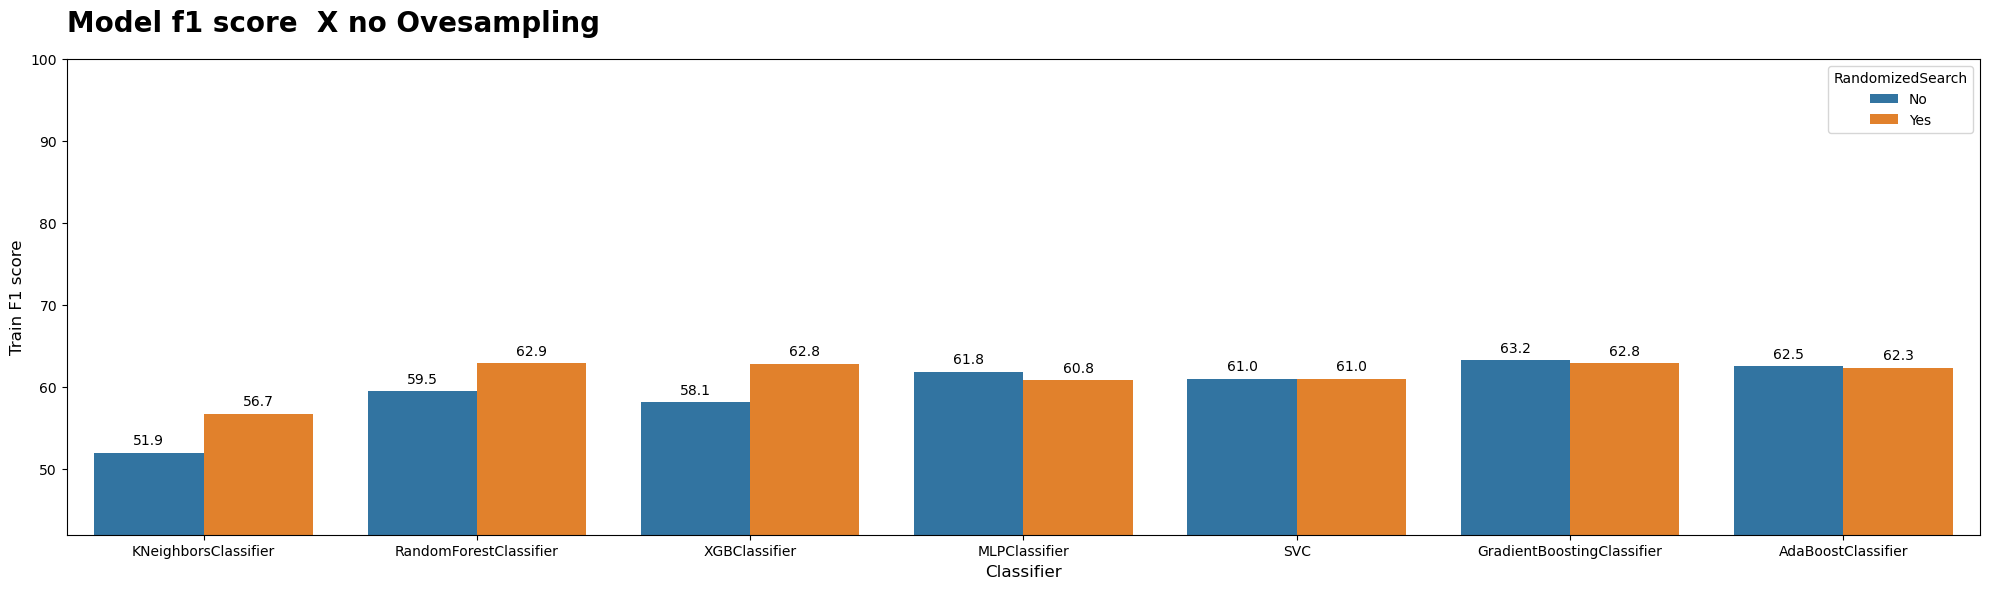

In [31]:
base_line_classifier_df['RandomizedSearch'] = 'No'
comparison = pd.concat([tuned_model, base_line_classifier_df[base_line_classifier_df['Model_name'].isin(['KNeighborsClassifier', 'RandomForestClassifier', 'XGBClassifier', 'MLPClassifier', 'SVC', 'GradientBoostingClassifier', 'AdaBoostClassifier'])]])
comparison['F1'] = comparison['F1']*100

ymin = comparison['F1'].min()

plt.figure(figsize=(20,6))
ax = sns.barplot(x='Model_name', y='F1', data=comparison, hue='RandomizedSearch', hue_order=['No', 'Yes'])
plt.title('Model f1 score  X no Ovesampling', size=20, fontweight='bold', pad=20, loc='left')
plt.ylabel('Train F1 score', size=12)
plt.xlabel('Classifier', size=12)
plt.ylim(ymin-10, 100)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')
plt.tight_layout()
plt.show()

### **Feature Selection**

For simplicity and time reasons, we will continue with only 3 models: RandomForestClassifier, XGBClassfier and GradientBoostingClassifier

In [32]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

In [33]:
# Instantiate models with the provided hyperparameters
random_forest_tuned_model = RandomForestClassifier(
    min_samples_split=5,
    min_samples_leaf=8,
    max_features='log2',
    max_depth=8,
    criterion='entropy',
    random_state=SEED
)

xgboost_tuned_model = XGBClassifier(
    subsample=0.8,
    objective='binary:logistic',
    n_estimators=100,
    min_child_weight=2,
    max_depth=3,
    learning_rate=0.1,
    colsample_bytree=0.9,
    random_state=SEED
)

gradient_boosting_tuned_model = GradientBoostingClassifier(
    subsample=1.0,
    n_estimators=50,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=3,
    learning_rate=0.1,
    random_state=SEED
)

# Create a list to store all the tuned models
pre_tuned_models_list = [
    random_forest_tuned_model,
    xgboost_tuned_model,
    gradient_boosting_tuned_model
]

#### **Recurssive Feature Elimination Cross Validation (rfecv)**

Creating a dictionary to store the pre-tuned model pipelines with rfecv for each classifier

In [34]:
# Instancing an stratified cv for the rfecv
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Pipe line wihtout classifier
rfecv_base_pipe = Pipeline([
    ('preprocessor', col_trans),
    ('resampler', SMOTE(random_state=SEED)),
    ('rfecv', RFECV(None, scoring='f1', cv=skf)), 
    ('classifier', None)
])

pre_tuned_pipelines_rfecv = generate_pipelines(pre_tuned_models_list, rfecv_base_pipe)

In [35]:
import os

def train_and_save_model(pre_tuned_pipelines_rfecv, X, y, save_dir="Model"):
    rfecv_model_results = []
    
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for model_name, pipeline in pre_tuned_pipelines_rfecv.items():
        # Splitting the data into training and testing set
        X_train, X_test, y_train, y_test = split_data(X, y)

        # Using the fit_model function to fit the pipeline with recursive feature elimination
        pipeline = fit_model(pipeline, X_train, y_train)

        # Access the 'classifier' step of the pipeline
        rfecv_step = pipeline.named_steps['rfecv']

        # Get the mask of selected features
        selected_features_mask = rfecv_step.support_

        # Getting the features names from the transformer step
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

        # Filtering the names of the selected features using the mask
        selected_feature_names = feature_names[selected_features_mask]

        # Getting and printing the metrics for the new model
        accuracy, precision, recall, f1, roc_auc = predict_score(pipeline, X_test, y_test)

        rfecv_model_results.append({'Model_name': model_name,
                    'Features Selected': selected_feature_names,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1': f1,
                    'ROC auc': roc_auc,
                    'Model': 'rfecv'})
        
        # Create a filename based on the model name and its performance metrics
        filename = f"{model_name}_recall_{round(recall, 4)}_f1_{round(f1, 4)}.pkl"
        save_path = os.path.join(save_dir, filename)
        
        # Save the trained model using joblib
        joblib.dump(pipeline, save_path)    

    return pd.DataFrame(rfecv_model_results)

In [36]:
test = train_and_save_model(pre_tuned_pipelines_rfecv, X, y, save_dir="Model")
test

,Model_name,Features Selected,Accuracy,Precision,Recall,F1,ROC auc,Model
0,RandomForestClassifier,"[num_pipeline__customer_tenure, num_pipeline__...",0.769340,0.547758,0.751337,0.633596,0.763591,rfecv
1,XGBClassifier,"[num_pipeline__customer_tenure, num_pipeline__...",0.775727,0.563043,0.692513,0.621103,0.749155,rfecv
2,GradientBoostingClassifier,"[num_pipeline__customer_tenure, num_pipeline__...",0.755855,0.528409,0.745989,0.618625,0.752705,rfecv


In [37]:
# Instancing an stratified cv for the rfecv
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

rfecv_model_results = []

for model_name, pipeline in pre_tuned_pipelines_rfecv.items():
    # Spliting the data into training and testing set
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Using the fit_model function to fit the pipeline with recursive feature elimination
    pipeline = fit_model(pipeline, X_train, y_train)

    # Access the 'classifier' step of the pipeline
    rfecv_step = pipeline.named_steps['rfecv']

    # Get the mask of selected features
    selected_features_mask = rfecv_step.support_

    # Getting the features names from the transformer step
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    # Filtering the names of the selected features using the mask
    selected_feature_names = feature_names[selected_features_mask]

    print(pipeline.named_steps['classifier'].__class__.__name__)
    print(f'From the {rfecv_step.n_features_in_} features, {rfecv_step.n_features_} remained')
    print(f'The features eliminated were {feature_names[~selected_features_mask]}')

    # Getting and printing the metrics for the ne model
    accuracy, precision, recall, f1, roc_auc = predict_score(pipeline, X_test, y_test)

    rfecv_model_results.append({'Model_name': model_name,
                'Features Selected': selected_feature_names,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'ROC auc': roc_auc,
                'Model': 'rfecv'})
    
rfecv_model = pd.DataFrame(rfecv_model_results)
rfecv_model

RandomForestClassifier
From the 25 features, 24 remained
The features eliminated were ['remainder__phone_PhoneService']
XGBClassifier
From the 25 features, 23 remained
The features eliminated were ['num_pipeline__account_Charges_Total'
 'num_pipeline__Average monthly Spend - Present monthly spend']
GradientBoostingClassifier
From the 25 features, 19 remained
The features eliminated were ['num_pipeline__Average monthly Spend - Present monthly spend'
 'cat_pipeline__customer_gender_Male'
 'cat_pipeline__account_PaymentMethod_Credit card (automatic)'
 'cat_pipeline__account_PaymentMethod_Mailed check'
 'remainder__customer_Partner' 'remainder__phone_PhoneService']


,Model_name,Features Selected,Accuracy,Precision,Recall,F1,ROC auc,Model
0,RandomForestClassifier,"[num_pipeline__customer_tenure, num_pipeline__...",0.769340,0.547758,0.751337,0.633596,0.763591,rfecv
1,XGBClassifier,"[num_pipeline__customer_tenure, num_pipeline__...",0.775727,0.563043,0.692513,0.621103,0.749155,rfecv
2,GradientBoostingClassifier,"[num_pipeline__customer_tenure, num_pipeline__...",0.755855,0.528409,0.745989,0.618625,0.752705,rfecv


#### **SelectKbest using chi2 method**

##### RandomForest

In [38]:
# Chi2 Pipeline
chi2_base_pipe = Pipeline([
    ('preprocessor', col_trans),
    ('resampler', SMOTE(random_state=SEED)),
    ('feature_selection', SelectKBest(chi2, k=22)), 
    ('classifier', None) # Set your desired k value here
])

# Generate new pipelines with the updated chi2_base_pipe
pre_tuned_pipelines_chi2 = generate_pipelines(pre_tuned_models_list, chi2_base_pipe)

In [39]:
chi2_model_results = []

for model_name, pipeline in pre_tuned_pipelines_chi2.items():
    # Spliting the data into training and testing set
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Using the fit_model function to fit the pipeline with recursive feature elimination
    pipeline = fit_model(pipeline, X_train, y_train)

    # Getting and printing the metrics for the ne model
    accuracy, precision, recall, f1, roc_auc = predict_score(pipeline, X_test, y_test)

    chi2_model_results.append({'Model_name': model_name,
                'Features Selected': selected_feature_names,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'ROC auc': roc_auc,
                'Model': 'chi2'})
    
chi2_model = pd.DataFrame(chi2_model_results)
chi2_model

,Model_name,Features Selected,Accuracy,Precision,Recall,F1,ROC auc,Model
0,RandomForestClassifier,"[num_pipeline__customer_tenure, num_pipeline__...",0.767211,0.545276,0.740642,0.628118,0.758727,chi2
1,XGBClassifier,"[num_pipeline__customer_tenure, num_pipeline__...",0.779986,0.568670,0.708556,0.630952,0.757177,chi2
2,GradientBoostingClassifier,"[num_pipeline__customer_tenure, num_pipeline__...",0.761533,0.535985,0.756684,0.627494,0.759985,chi2


In [40]:
tuned_model_2 = tuned_model[tuned_model['Model_name'].isin(['RandomForestClassifier', 'XGBClassifier', 'GradientBoostingClassifier'])]
tuned_model_2.loc[:, 'Model'] = 'Tuned model'

C:\Users\ferna\AppData\Local\Temp\ipykernel_6884\3392652385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tuned_model_2.loc[:, 'Model'] = 'Tuned model'


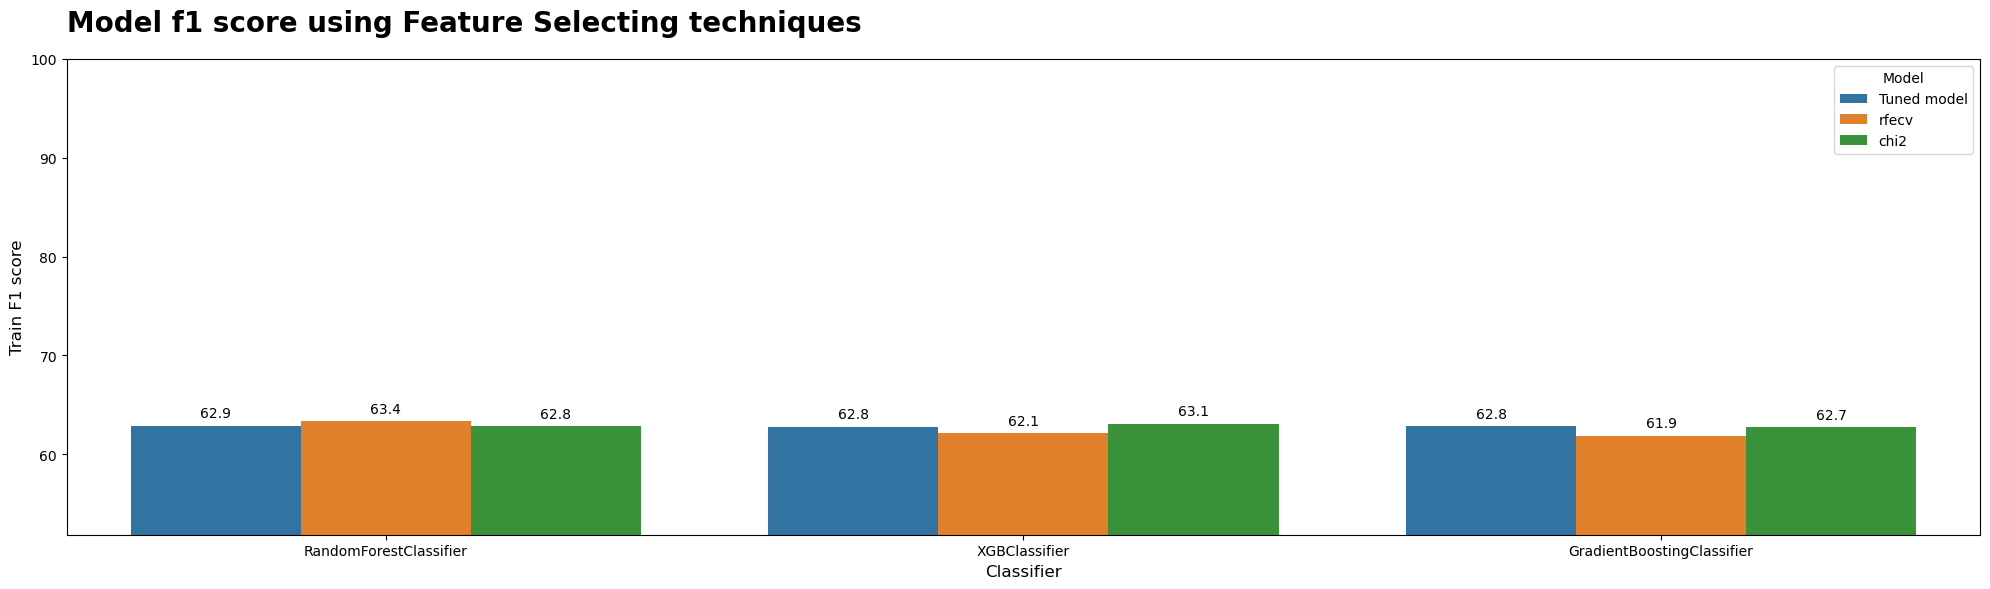

In [41]:
comparison = pd.concat([rfecv_model, chi2_model, tuned_model_2])
comparison['F1'] = comparison['F1']*100

ymin = comparison['F1'].min()

plt.figure(figsize=(20,6))
ax = sns.barplot(x='Model_name', y='F1', data=comparison, hue='Model', hue_order=['Tuned model', 'rfecv', 'chi2'])
plt.title('Model f1 score using Feature Selecting techniques', size=20, fontweight='bold', pad=20, loc='left')
plt.ylabel('Train F1 score', size=12)
plt.xlabel('Classifier', size=12)
plt.ylim(ymin-10, 100)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')
plt.tight_layout()
plt.show()

Our best model during the feature selection phase was the RandomForestClassifier using the RFECV method from sklearn. 

#### Saving the Optimized Model

In [42]:
import joblib

best_model = pre_tuned_pipelines_rfecv['RandomForestClassifier']

model_name = best_model['classifier'].__class__.__name__
file_name = 'Model/' + model_name + '_recall_' + str(round(recall, 4)) + '_f1_' + str(round(f1, 4)) +'.pkl'
joblib.dump(best_model, file_name)

['Model/RandomForestClassifier_recall_0.7567_f1_0.6275.pkl']

In [43]:
best_model = pre_tuned_pipelines_rfecv['RandomForestClassifier']

# Spliting the data into training and testing set
X_train, X_test, y_train, y_test = split_data(X, y)

# Using the fit_model function to fit the pipeline with recursive feature elimination
best_model = fit_model(best_model, X_train, y_train)